# Explainable Artificial Intelligence

In this exercise we will explore two techniques used to transform a black box into a white box, provinding an explanation to the decision taken by an algorithm

Explaining the decision path followed by an algorithm is important in a number of applications. 
For example, in the past it was used to debug artificial intelligence algorithms helping to identify artifacts in images sufficient to perfectly discriminate them without actually learning to decode their content. 
On the other hand, a lot of attention on XAI comes from applications in medicine in which the reasoning behind the decision of an algorithm is critical to effectively support clinicians.

In this exercise we will try to use explainable AI to identify patterns in a very long sequence of RNA editing sites sufficient to discriminate men and women.

Indeed, while it is known from the literature that [Computer Vision algorithms applied to genetic sequences can classify pathologies](https://www.biorxiv.org/content/10.1101/364323v1) it is still unclear which genes are responsible, or in other words which patters are used by the algorithm to correctly identify pathologies.

## Importing libraries and dataset

The dataset used for this excercise is GTEx, a publc dataset that was preprocessed for the hackathon and uploaded in a [pandora repository](https://pandora.infn.it/public/728eb4).

In [1]:
# Install missing libraries
!pip install -q pyreadr
!pip install -q opencv-python
!pip install -q shap
!pip install -q tqdm
!pip install -q jupyslides
!pip install -q pypandoc
!pip install -q jupyslides

# Download the dataset
!wget -q https://pandora.infn.it/public/f9cc77/dl/DB_test.RData
!wget -q https://pandora.infn.it/public/dfa7fa/dl/DB_train.RData
!wget -q https://pandora.infn.it/public/c7d054/dl/lab_test.npy
!wget -q https://pandora.infn.it/public/9940cc/dl/lab_train.npy
!wget -q https://pandora.infn.it/public/7c91a8/dl/model_comp.h5

# Import libraries
## Data management
import numpy as np
import pyreadr as pr   #Rdata to python
import pandas as pd

## Standard Python Libraries
import random
import math
import os
import pickle
from time import time, sleep

## Images and plots
from matplotlib import pyplot as plt
import cv2 #manipulating images

## Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K

## Additional utilities
from tqdm import tqdm, trange
from sklearn.metrics import confusion_matrix

## Explainable AI libraries
import shap

## We disable eager execution of tensorflow 2 to simplify the 
## code used to compute the gradients.
## Note that with some additional boilerplate (GradientTape) you could achieve 
## the same results without disabling eager execution that may be useful for 
## some applications.
tf.compat.v1.disable_eager_execution()

In [2]:
from jupyslides import jupyslides
slides_path = 'Presentation'
js = jupyslides(slides_path)
slides=js.slideshow()

interactive(children=(FloatSlider(value=1.0, description='zoom', max=2.0, min=0.6, step=0.2), IntSlider(value=…

# Data preparation

Let's start with loading the data. 
The training and test datasets are available in RData format, while the labels were stored as uncompressed numpy arrays.

In [3]:
# Training set
DB_balanced = pr.read_r('DB_train.RData')['DB_train']

# Test set
DB_test = pr.read_r('DB_test.RData')['DB_test']

# Training label
lab_train = np.load('lab_train.npy')

# Test label
lab_test = np.load('lab_test.npy')

## Exploratory analysis

The datasets we have loaded are made of a long list of rows corresponding to different *samples*.

For each row there is a long list of features, each corresponding to an editing site.


The names of the columns provide the number of a chromosome and the index of a the editing site on that chromosome.

Editing site indices may be repeated in different chromosomes. 

In [4]:
# Training set
print(DB_balanced.iloc[:10,:5])
print(DB_balanced.shape)

# Test set
print(DB_test.iloc[:10, :5])
print(DB_test.shape)

              chr1_136052  chr1_136915  chr1_564461  chr1_564467  chr1_567459
rownames                                                                     
SRR1313426       0.465523     0.208592     0.337590     0.229242     0.005040
SRR1433088.2     0.465523     0.208592     0.337590     0.229242     0.007031
SRR1343115.1     0.465523     0.200000     0.337590     0.229242     0.007031
SRR660895.1      0.324680     0.193550     0.337590     0.229242     0.007031
322              0.250647     0.125343     0.337590     0.229242     0.007031
SRR1432123       0.733330     0.250000     0.337590     0.142860     0.007031
88               0.463340     0.208592     0.328383     0.225002     0.005138
SRR1396659       0.465523     0.208592     0.337590     0.229242     0.007031
SRR1436444       0.465523     0.208592     0.337590     0.229242     0.010870
SRR1404969       0.611110     0.133330     0.337590     0.229242     0.007031
(1472, 86683)
            chr1_136052  chr1_136915  chr1_564461 

## Labels

Labels are provided in the form of chars, one per row, with
 * `'0'` indicating a male
 * `'1'` indicating a female
 
We aim at identifying those sites that can identify a difference between men and women.

In [5]:
# Training label
print(lab_train[:10])
print(f"Training Label lenght = {len(lab_train)}.\n")

# Test label
print(lab_test[:10])
print(f"Test Label lenght = {len(lab_test)}.\n")

['1' '0' '0' '0' '1' '1' '1' '1' '1' '1']
Training Label lenght = 1472.

['0' '0' '0' '0' '0' '0' '0' '0' '0' '0']
Test Label lenght = 307.



## Ordering the dataset

The order of the columns in the dataset is important as features may arise from patterns of adjacent sites. 
We want the columns to be ordered by chromosome first, and then by editing site index. 

To achieve this result, we define two functions using regular expressions to extract the chromosome number and the site index from the column name.
Then we fill a pandas dataframe with the chromosome and the site, and we sort by the chromosome number first, and then by editing site using the [`sort_values`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html) function of pandas DataFrames.

Then we drop the index column and we copy the dataframe to avoid possible hidden links between the loaded and ordered pandas DataFrame.

In [6]:
import re

def extract_chromosome_list(dataframe):
    """Obtain a list of chromosome numbers from the columns of a dataframe"""
    return [int(re.findall(r"chr([0-9]*)_[0-9]*", column)[0]) for column in dataframe]

def extract_site_list(dataframe):
    """Obtain a list of editing site index from the columns of a dataframe"""
    return [int(re.findall(r"chr[0-9]*_([0-9]*)", column)[0]) for column in dataframe]

def ordered_columns(dataframe):
    """Return the list of columns, ordered by chromosome first and the by sample"""
    chromosomes = np.array(extract_chromosome_list(dataframe))
    df = pd.DataFrame(dict(
        colname=list(dataframe.columns),
        chromosome=chromosomes,
        site=extract_site_list(dataframe)
    ))
    return df.sort_values(by=['chromosome', 'site']).colname.to_list()


## Sort the dataset according to the chromosome number
Editing_ord = (
    DB_balanced[ordered_columns(DB_balanced)]    # Sort the dataset
    .reset_index()                               # Remove the role of index to the rownames column
    .drop(columns='rownames')                    # Drops the rownames column
    .copy()                                      # Copy the dataset to avoid possible memory 
)                                                #   links between the two dataframes.

### Visualize the effect of sorting
To visualize the effect of the sorting, we plot the chromosome and site indices as a function of the row index before and after.

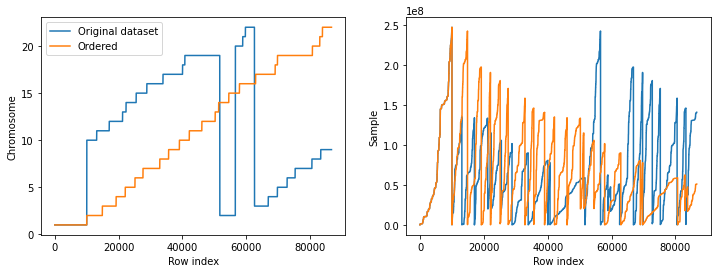

In [7]:
## Check the ordering is successful
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(extract_chromosome_list(DB_balanced), label="Original dataset")
plt.plot(extract_chromosome_list(Editing_ord), label="Ordered")
plt.legend()
plt.xlabel("Row index")
plt.ylabel("Chromosome")
plt.subplot(1,2,2)
plt.plot(extract_site_list(DB_balanced), label="Original dataset")
plt.plot(extract_site_list(Editing_ord), label="Ordered")
plt.xlabel("Row index")
plt.ylabel("Sample")

plt.show()

## Converting the dataset in a sequence of images

Following the steps of [Boyu Lyu and Anamul Haque](https://www.biorxiv.org/content/10.1101/364323v1) to adopt computing vision algorithms to gene expression sequences, we convert the sequences into images.

To do this, we will wrap the sequence in random points aiming at squared figures.
As the length of the sequence is not a perfect square number, we will pad the sequence with zeros before reshaping it into a square image.

In the code block below we compute the number of zeros necessary to pad the sequence.

In [8]:
## Converting the sequences in a square image
n_rows, n_columns = Editing_ord.shape
root = math.sqrt(n_columns)
perf_square = math.ceil(root)
print(f"Square root of the feature number = {root:.2f}. Approximated to {perf_square:.1f} \n")

n_zero = perf_square**2 - n_columns
print(f"Number of positions to be padded with zeros: {perf_square**2} - {n_columns} = {n_zero}. \n")

Square root of the feature number = 294.42. Approximated to 295.0 

Number of positions to be padded with zeros: 87025 - 86683 = 342. 



### Padding and reshaping the sequence
The next block does the following:
 * Create a block of zeros $\mathbf{0}_{N_{\rm rows} \times N_{\rm zero}}$
 * Extract the values from the DataFrame as a 2D matrix $\mathbf {D}_{N_{\rm rows}\times N_{\rm cols}}$
 * Concatenates the two into the padded matrix
 $$
 \mathbf{P} = \left( 
     \begin{array}{cc}
         \mathbf {D}_{N_{\rm rows}\times N_{\rm cols}} & \mathbf{0}_{N_{\rm rows} \times N_{\rm zero}}
     \end{array}
     \right)
 $$
 * Reshape the tensor into $\mathbf{T}_{N_{\rm rows} \times N_q \times N_q}$ where $N_q = \mathrm{ceil}\left(\sqrt{N_{\rm cols}}\right)= \sqrt{N_{\rm cols} + N_{\rm zero}}$

In [9]:
zeros = pd.DataFrame(np.zeros((n_rows,n_zero)))
images_train = Editing_ord.values
images_train = np.concatenate((images_train, zeros), axis=1).reshape((-1, perf_square, perf_square, 1))

### Repeating the procedure with the test sample

Same steps as described above are repeated on the test sample.

In [10]:
# Test
## Sort the dataset according to the chromosome number
image_test = (
    DB_test[ordered_columns(DB_test)] 
    .reset_index() 
    .drop(columns='rownames') 
    .values
)
zero_padding = np.zeros([len(DB_test), perf_square**2-len(DB_test.columns)])
images_test = np.concatenate((image_test, zero_padding), axis=1).reshape((-1, perf_square, perf_square, 1))

## Visualization of some of the images
We report below the first image obtained by wrapping the gene sequence as described above.
We note that the pattern is clearly horizontal which means that the human eye is able to capture correlations between horizontally adjacent pixels.
While vertically aligned pixels are aligned by a mere coincidence, adding few more editing sites, $N_q$ would change and the alignement would be lost.

To visualize the contributions from different chromosomes, we color the image to highlight different stripes corresponding to different chromosomes.

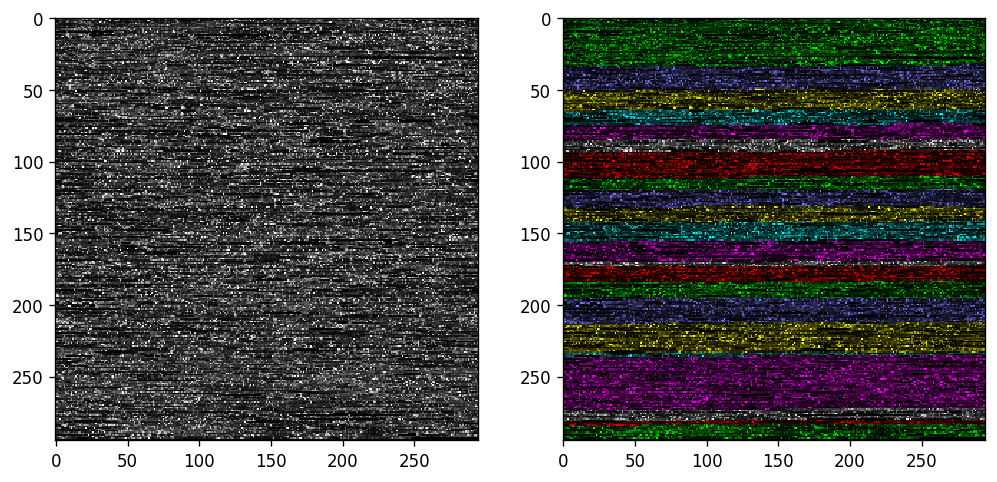

In [11]:
chromosome = extract_chromosome_list(Editing_ord.columns)
chromosome = np.concatenate((chromosome, np.zeros(n_zero)))
chromosome = chromosome.reshape((perf_square, perf_square))
colors = np.array([
    [1., 0., 0.],
    [0., 1., 0.],
    [.5, .5, 1.],
    [1., 1., 0.],
    [0., 1., 1.],
    [1., 0., 1.],
    [1., 1., 1.],

])

rgb = np.stack([np.select([chromosome % len(colors) == i for i in range(len(colors))], colors[:,comp], default=0.) for comp in range(3)], axis=-1)

plt.figure(figsize=(10,5), dpi=120)
plt.subplot(1,2,1)
plt.imshow(images_train[0], interpolation='none', cmap='gray')
plt.subplot(1,2,2)
plt.imshow(images_train[0]*rgb, interpolation='none')
plt.show()

## Conversion to float 
By default, python and numpy represent floating point numbers with 64 bits.
As customary in Computer Vision, we shrink the precision to 32 to make computations faster.

In [12]:
## Conversion to float
train = np.array(images_train, dtype=np.float32)
test = np.array(images_test, dtype=np.float32)
train_label = np.array(list(map(int, lab_train)), dtype=np.float32)
test_label = np.array(list(map(int, lab_test)), dtype=np.float32)

# Model building

Inspired from Computer Vision, we will design a simple Convolutional Neural Network to perform a binary classification between male and female candidates. 

To avoid injecting into the CNN random patterns due to the vertical alignment of unrelated pixels, we will use 1D kernels. 

A schematic representation of the designed deep neural network is presented below. Green layers include weights to be optimized.
![](https://codimd.web.cern.ch/uploads/upload_7ee7a78f5d8e52cc6d5c4e459439a6d4.png)

Given the large number of parameters, we will need important regularization functions to avoid overfitting of the model.

In [13]:
# Model Building
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=(1,9),
    activation='relu',
    kernel_regularizer=regularizers.L2(1e-3),
    activity_regularizer=regularizers.L2(1e-3),
    kernel_initializer='he_normal',
    bias_regularizer=regularizers.L2(1e-3),
    input_shape=(perf_square,perf_square,1)
))

model.add(tf.keras.layers.MaxPool2D(
    pool_size=(1,8),
))

model.add(tf.keras.layers.SpatialDropout2D(0.3))

model.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=(1,7),
    activation='relu',
    kernel_regularizer=regularizers.L2(1e-3),
    activity_regularizer=regularizers.L2(1e-3),
    kernel_initializer='he_normal',
    bias_regularizer=regularizers.L2(1e-3),
    name='conv_2'
))

model.add(tf.keras.layers.MaxPool2D(
    pool_size=(1,4),
))

model.add(tf.keras.layers.SpatialDropout2D(0.3))

model.add(tf.keras.layers.Flatten())


model.add(tf.keras.layers.Dense(units=64,
    kernel_regularizer=regularizers.L2(1e-3),
    activity_regularizer=regularizers.L2(1e-3),
    kernel_initializer='he_normal',
    bias_regularizer=regularizers.L2(1e-3),
    activation='sigmoid'
    ))

model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=1,
    kernel_regularizer=regularizers.L2(1e-3),
    activity_regularizer=regularizers.L2(1e-3),
    kernel_initializer='he_normal',
    bias_regularizer=regularizers.L2(1e-3),
    activation='linear'
    ))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy']
              )

2022-11-17 13:52:10.211645: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 13:52:10.217673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 13:52:10.218944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Summary of the model

We can compare the schematic representation of the CNN with the summary obtained by keras, which includes the number of parameters.

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 295, 287, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 295, 35, 32)      0         
 )                                                               
                                                                 
 spatial_dropout2d (SpatialD  (None, 295, 35, 32)      0         
 ropout2D)                                                       
                                                                 
 conv_2 (Conv2D)             (None, 295, 29, 64)       14400     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 295, 7, 64)       0         
 2D)                                                             
                                                        

## Training

In [15]:
history=model.fit(train,
                  train_label,
                  epochs=200,
                  batch_size=40,
                  validation_split=0.2,
                  verbose = 1)

hist=history.history

Train on 1177 samples, validate on 295 samples


2022-11-17 13:52:10.673343: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 13:52:10.674281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 13:52:10.675594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 13:52:10.676848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Epoch 1/200


2022-11-17 13:52:11.981929: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2022-11-17 13:52:13.257290: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1177/1177 [==============================] - ETA: 0s - loss: 275.8353 - accuracy: 0.5106

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


1177/1177 [==============================] - 7s 6ms/sample - loss: 275.8353 - accuracy: 0.5106 - val_loss: 186.2375 - val_accuracy: 0.4746
Epoch 2/200
1177/1177 [==============================] - 4s 3ms/sample - loss: 162.2167 - accuracy: 0.5174 - val_loss: 136.1759 - val_accuracy: 0.4746
Epoch 3/200
1177/1177 [==============================] - 4s 3ms/sample - loss: 119.6876 - accuracy: 0.5021 - val_loss: 101.6186 - val_accuracy: 0.4746
Epoch 4/200
1177/1177 [==============================] - 4s 3ms/sample - loss: 90.2042 - accuracy: 0.5183 - val_loss: 77.2247 - val_accuracy: 0.4746
Epoch 5/200
1177/1177 [==============================] - 4s 3ms/sample - loss: 69.1677 - accuracy: 0.5183 - val_loss: 59.6770 - val_accuracy: 0.4746
Epoch 6/200
1177/1177 [==============================] - 4s 3ms/sample - loss: 53.8635 - accuracy: 0.5387 - val_loss: 46.7522 - val_accuracy: 0.5356
Epoch 7/200
1177/1177 [==============================] - 4s 3ms/sample - loss: 42.5032 - accuracy: 0.5489 - val_

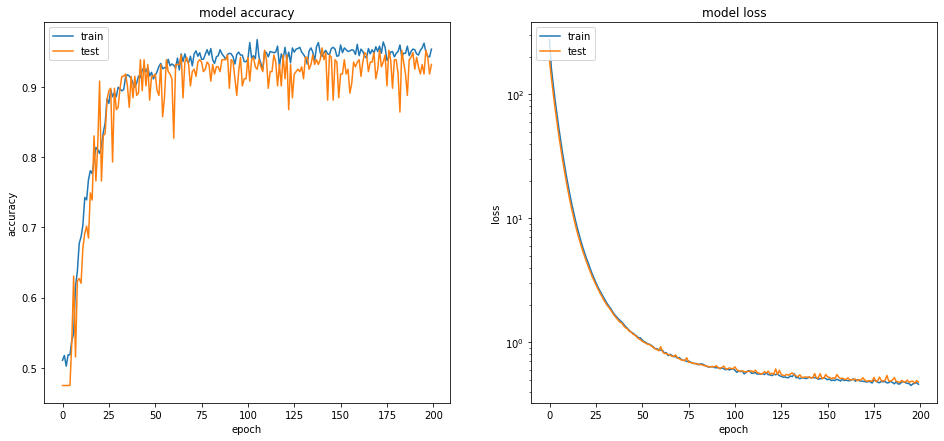

In [16]:
# summarize history for accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')
# summarize history for loss
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
plt.yscale('log')
plt.show()

## Performance assessment

Let's make a histogram of the raw response of the Convolutional Neural Network

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


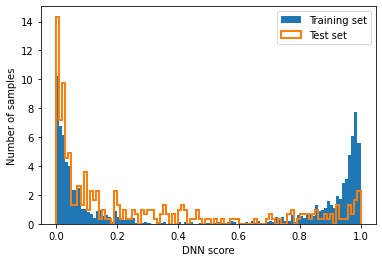

In [17]:
# Model load
#model = tf.keras.models.load_model('model_comp.h5')
#model.evaluate(test, test_lab)


def sigmoid(x):
    return 1./(1 + np.exp(-x))

y_train_pred = sigmoid(model.predict(train))
y_test_pred = sigmoid(model.predict(test))


plt.hist(y_train_pred, bins=np.linspace(0, 1, 101), label="Training set", density=True)
plt.hist(y_test_pred, bins=np.linspace(0, 1, 101), label="Test set", density=True, histtype='step', linewidth=2)
plt.xlabel("DNN score")
plt.ylabel("Number of samples")
plt.legend()
plt.show()


## Additional Metrics
Then we compute some metrics and show the confusion matrix on the test dataset.

In [18]:
y_pred = (y_test_pred > 0.5).astype(np.float64)
lab = np.array([int(numeric_string) for numeric_string in lab_test])

cm1 = confusion_matrix(lab, y_pred)
print('Confusion Matrix : \n', cm1)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1 = (cm1[0,0] + cm1[1,1])/total1
print('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0] + cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0] + cm1[1,1])
print('Specificity : ', specificity1)

Confusion Matrix : 
 [[226   6]
 [ 19  56]]
Accuracy :  0.9185667752442996
Sensitivity :  0.9741379310344828
Specificity :  0.7466666666666667


## Qualitative conclusion
It is clear that the model is able to distinguish men and women from the gene sequence with decent performance.
And this is more or less expected, as the genetic sequence in men and women are acceptably different. 
> But how does the network manage to achieve this conclusion?


# Explainable AI - GradCAM

Given the model, we will try to identify those regions of the image that are more relevant to the outcome of the neural network.

We will start with applying the GradCAM technique which is described in the paper [Grad-CAM: Visual Explanations from Deep Networks
via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf).

As made clear by the title, GradCAM is a technique providing a *Visual Explaination* and for this reason it is mainly intended for Computer Vision applications,
identifying those portions of an image that are the most relevant to push the classification towards a given category.
The following pictures taken from the Grad-CAM paper show how the classification of this image into a Cat or Dog category is driven by different areas of the image.

![](https://codimd.web.cern.ch/uploads/upload_032f66b28b2810bc105bb457d16061df.png)
![](https://codimd.web.cern.ch/uploads/upload_9d2150efdc9824596b2f201fb6f28c3c.png)
![](https://codimd.web.cern.ch/uploads/upload_641691525d02d8c2253ddd8a6f48be2f.png)

To achieve this result, GradCAM computes the partial derivatives of the network output with respect to the feature map $\frac{\partial \hat y_c}{\partial A^k_{ij}}$, where:

 * $\hat y_c$ is the estimator of the label as obtained by the CNN
 * the feature map $A^k_{ij}$ is a map of the highest-level features in our CNN that are still related to a portion of the image. 
   A common way to obtain the feature map is to take the output of the last convolutional layer of the CNN.
   The indices $i$ and $j$ run on the rows and the columns of the feature maps, encoding the spatial information, while $k$ runs over the channels or features 
   obtained by the multiple *filters* of the Convolutional Layer. In the case of our CNN, the last Convolutional Layer is defined as
   
```python
    tf.keras.layers.Conv2D(
    filters=64, kernel_size=(1,7),
    activation='relu',
    kernel_regularizer=regularizers.L2(1e-3),
    activity_regularizer=regularizers.L2(1e-3),
    kernel_initializer='he_normal',
    bias_regularizer=regularizers.L2(1e-3),
    name='conv_2'
    )
```
hence, the index $k$ runs on the $F=64$ feature maps generated as an output.

Once we know  $\frac{\partial \hat y_c}{\partial A^k_{ij}}$, we have to combine it into a single map of importance. We split the procedure in two steps.
First, we compute the importance $\alpha_k^c$ to predict each category of each feature map
$$
\alpha_k^c = \frac{1}{N_{\rm rows} N_{\rm cols}} \sum_{i=1}^{N_{\rm rows}} \sum_{j=1}^{N_{\rm cols}} \frac{\partial \hat y_c}{\partial A^k_{ij}}
$$
this step is named *Global Average Pooling* and results into a vector $\alpha_k^c$ of $F$ elements (64 in our example).

The second step is to combine the importance of each feature map with the values of the feature maps to identify those regions where the most important features are more present. To select only those regions where the gradients speak for and not against a given category, it is customary to remove the negative values by applying a ReLU to the linear combination of weights and feature maps.
$$
L^{c}_{\mathrm {GradCAM}, ij} = \mathrm{ReLU}\left(\sum_{k=1}^{F} \alpha_k^c A^{k}_{ij}\right)
$$
**Important.** Note that $A^{k}_{ij}$ is a non-negative quantity because the Convolutional Layer is defined using a ReLU as an activation function.

As a final step we will need to reshape the matrix $L^{c}_{\mathrm {GradCAM}, ij}$ to match the size of the original image, and possibly reshape the two.


Now you have the idea. Let's do it!

#### Retrieve the latest convolutional model

Obtain the last Convolutional Layer, you can use for example the [function `get_layer`](https://keras.io/api/models/model/#getlayer-method) of the CNN trained above.
```python
conv = ...
```

#### Retrieve the model output and feature maps
Obtain the output of the model as `model.output` and the feature maps as output of the convolutional layer `conv.output`
```python
y_hat = ...
f_map = ...
```

#### Compute the gradients for the two classes, Male ($y=0$) and Female ($y=1$)
Gradients can be computed in TensorFlow 2 with the [function `tf.gradients`](https://www.tensorflow.org/api_docs/python/tf/gradients).
Note that `tf.gradients` returns a list of gradients, one for each input variable (which is one in our case), so to access the gradient you will need a `[0]` somewhere.

```python
grads_F = tf.gradients(y_hat, f_map)
```

Once we have the gradients we install them into a [`tf.function` object]() to ease evaluation of the gradients for different feature maps.
There at least two equivalent ways of doing this:
##### with a keras function
 ```python
 get_gradients_F = keras.backend.function(inputs=model.input, outputs=[f_map, grads_F])
 ...
 my_f_map, my_grads_F = get_gradients_F(my_input_image)
 ```
##### with a keras Model
 ```
 get_gradients_F = keras.Model(inputs=[model.input], outputs=[f_map, grads_F])
 get_gradients_F.compile()
 ...
 my_f_map, my_grads_F = get_gradients_F.predict([my_input_image])
 ```
 
To the purpose of the exercise they are completely equivalent.


> **Important: Don't forget to create the get_gradients function also the male ($y=1$) category**
```python
grads_F = ...
get_gradients_F = ...

grads_M = ...
get_gradients_M = ...
```

### Define the gradcam computation function

Define a function that takes as an input an image, say `X`, and the `label` of that image and return the coresponding GradCAM matrix $L^{\tt label}_{\rm GradCAM}$.

```python
def compute_grad_cam(X, label):
    ...
    return grad_cam
```

### Visualize the GradCam
To visualize the outcome of the GradCam, it is useful to normalize, reshape and colorize the matrix.
We will use OpenCV2 to the purpose, but with some more gymnastic you may achieve very similar results with `matplotlib`.

In [23]:
def process_to_visualize(grad_cam, shape, img=None, colorize=True):
    "Process the grad_cam 2D array to make it possible to superpose it to the original image"
    grad_cam = cv2.resize(grad_cam, shape, cv2.INTER_NEAREST)# rescale the gradcam output to the shape of the image
    grad_cam = grad_cam / grad_cam.max()                     # normalize the output of the gradcam to unity
    if colorize:
        grad_cam = cv2.applyColorMap(np.uint8(255 * grad_cam), cv2.COLORMAP_JET) # applies some coloring
    grad_cam = np.float32(grad_cam)
    if img is not None:
        grad_cam = (grad_cam + img) / 2                      # superpose the gradcam to the image, if provided
    
    return np.uint8(grad_cam)                                # Converts the image back to 8-bit unsigned ints (standard for images)

### Take the average GradCAM on a set of images
GradCAM is able to tell us which parts of the image (or in our example which portions of the chromosomes) played a role in the assignment of a given sample to a category (male or female).
However, our question is rather which portions of the DNA are, *on average*, the most relevant to the determination of the class.

To achieve this, we will take the average of the GradCam results over the test sample, split in male and female subsets.

To begin with, write the function that takes the average over a set of images, after applying the `process_to_visualize` function.

```python
def grad_cam_mean(dataset, shape, label_class, label_class):
    # for each row of the dataset, 
    #  * compute_grad_cam for that row
    #  * process_to_visualize the returned gradcam
    # Finally return the mean of all the processed gradcam:
    return average_grad_cam
```

### Apply the average GradCAM on a set of images
Finally, apply the GradCAM to the male and female candidates.

```python
...
test_F = ... # test dataset of female entries
test_M = ... #  "      "     " male entries
grad_cam_F = grad_cam_mean(test_F, ...)
grad_cam_M = grad_cam_mean(test_M, ...)
```

In [25]:
#grad_cam application
test = np.array(images_test)
shape = (perf_square, perf_square)
test_F = test[lab_test=='1']
test_M = test[lab_test=='0']
grad_cam_F = grad_cam_mean(test_F, shape=shape, label_class=1)
grad_cam_M = grad_cam_mean(test_M, shape=shape, label_class=0)

100%|██████████| 232/232 [00:01<00:00, 194.98it/s]


### Draw the result

Draw the results. You can use a code on the line of the following:
```python
plt.figure(figsize=(21,12), dpi=120)
plt.subplot(1,3,1)
plt.imshow(test[0]*rgb, cmap='gray', aspect='auto', interpolation='none')
plt.title("Original image")
plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(np.uint8(grad_cam_F), cv2.COLOR_BGR2RGB), aspect='auto', interpolation='none')
plt.title('Female')
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(np.uint8(grad_cam_M), cv2.COLOR_BGR2RGB), aspect='auto', interpolation='none')
plt.title('Male')
plt.show()
```
that should result more or less in a figure like
![](https://codimd.web.cern.ch/uploads/upload_8f692c71877742fe82cd6034e4760327.png)

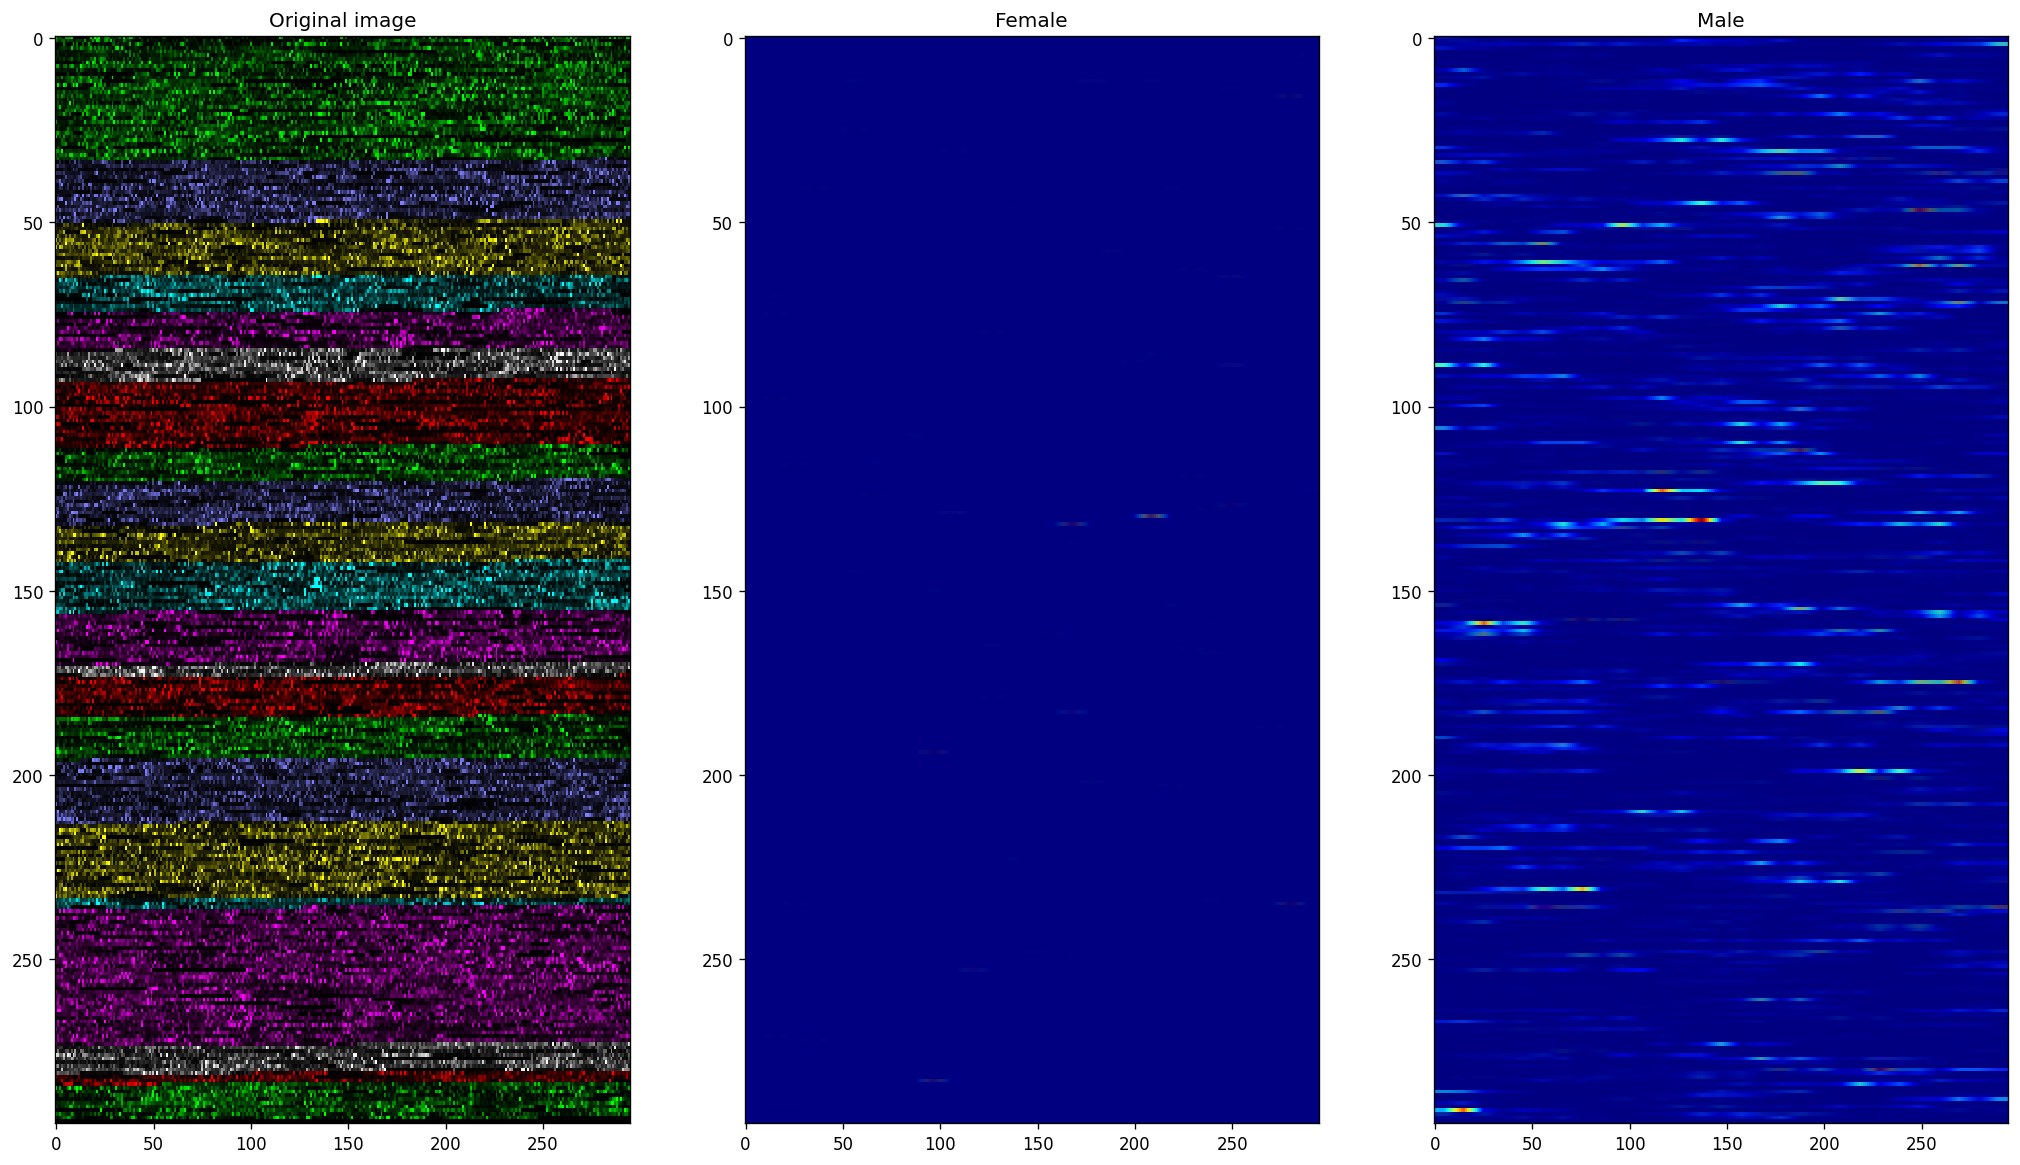

# Shapley
The Shapley method is a generic Explainable AI tool to assess the importance of a feature contributing to the outcome of a black-box algorithm applied to a given data entry. The Shapley method originates from Game Theory to describe the training of the model as a cooperative game to which a different set of players (the features) may take part. The idea is to identify the subset of features the most important to win the game, or to train the model. A feature occuring in most of the winning subsets will score higher than a feature rarely needed to win the game.

For a brief introduction to the subject, you can have a look to this [post on *Towards Data Science* by Samuele Mazzanti](https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30).

In this exercise we will use a version of the Shapley method with several approximations tuned to deal with Computer Vision models with a large number of features.
The Python package providing these functionalities is [`shap` by Scott Lundberg](https://shap.readthedocs.io/en/latest/index.html).

Let's start defining a `DeepExplainer` class, documented [here](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html), whose construction takes as an input the trained model and a set of trained features. 

Since the method is rather eager in terms of computing resources, it is a better idea to limit the training sample to some tens of entries.

In [27]:
explainer = shap.DeepExplainer(model, train[0:20])

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


Then we use the explainer to obtain the *shap_values*, representing a measure of the importance of each feature.

In [28]:
shap_values = explainer.shap_values(test[0:20])

Finally, we display some of the results.
To interpret these figures it is useful to compare them with the [example] provided by the author of the shap package for MNIST 
![image.png](https://shap-lrjball.readthedocs.io/en/latest/_images/example_notebooks_deep_explainer_Front_Page_DeepExplainer_MNIST_Example_3_0.png)

In this example we can see examples of the four differently labeled digits (1 to 4) corresponding to four different rows. Each of the ten columns (skipping the first one) shows the regions of the image pusing towards the classification as 0 to 9. 
Note for example that the upperside of the "4" digit is particularly critical to distiguish it from a "9". This is visualized by the Shapley method with a blue band on top of image of a four digit when interpreting it as a 9 (last column).

Back to our binary classification, now. What are the regions the more relevant to identify the gender?

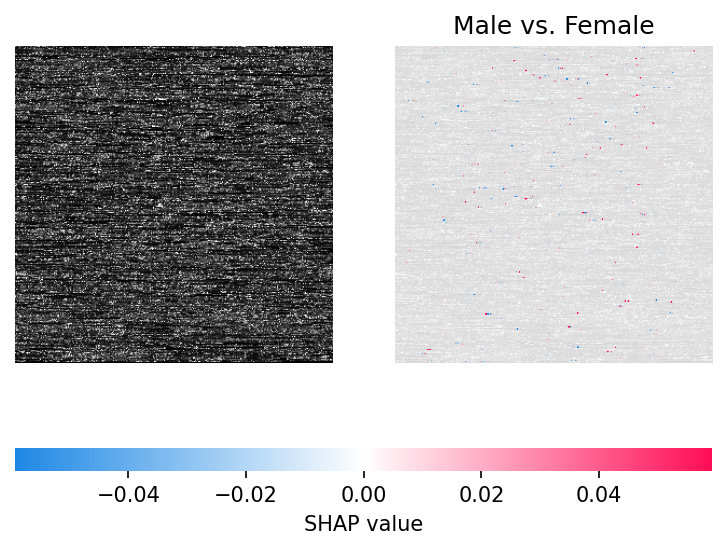

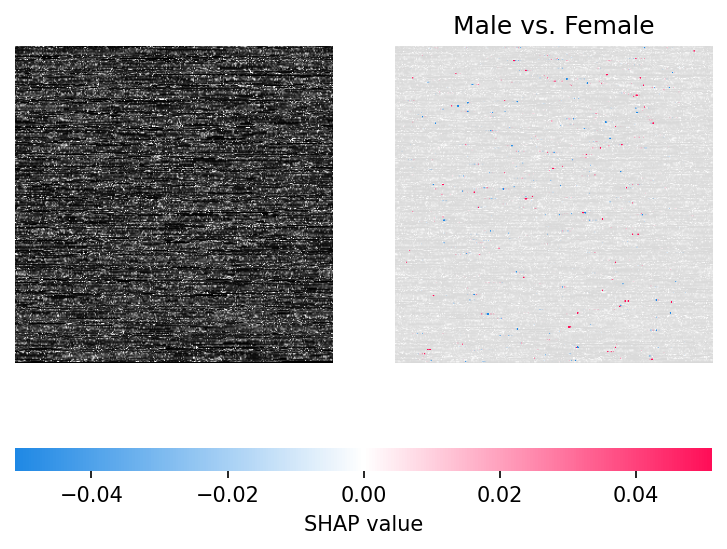

In [29]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
for test_example in test[:2]:
    shap.image_plot(explainer.shap_values(test_example[None]), test_example[None], labels=["Male vs. Female"])

As done before, let's take the average of the Shapley values through the whole sample to compute the average importance of genetic sequences.

1
(295, 295, 1)


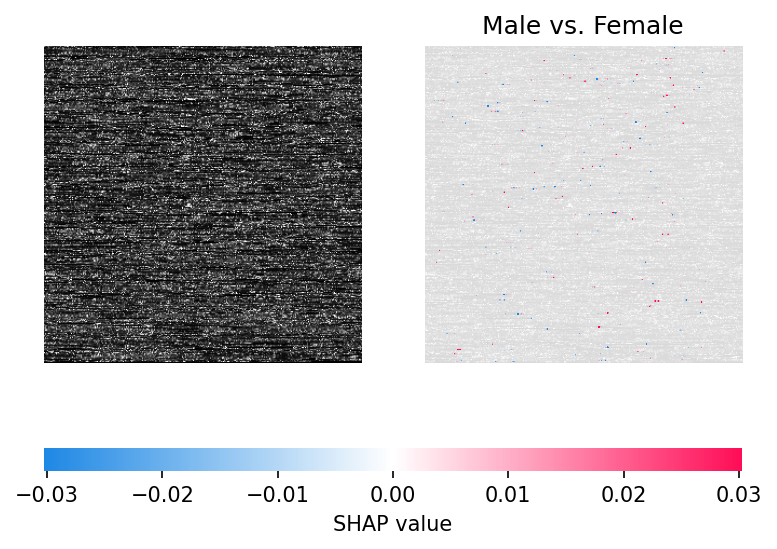

In [30]:
w2 = np.array(shap_values)[0].mean(axis=0)
shap.image_plot(w2, test[0], labels=["Male vs. Female"])

### Using `shap`'s Gradient Explainer
In the `shap` library there is also an explainer using Gradients to approximate Shapely values, it is named `GradientExplainer` and is documented [here](https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/gradient_explainer/Multi-input%20Gradient%20Explainer%20MNIST%20Example.html).

Try to define a `GradientExplainer` and to use it to describe the importance of the feature map obtained at the end of the second convolutional layer.

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


You can use a function similar to the one below to represent the results.
```python
avg = shap_values2[0].mean((0, 3))
reshaped = cv2.resize(avg, shape, cv2.INTER_NEAREST)# rescale the gradcam output to the shape of the image
plt.figure(figsize=(20,7))
plt.subplot(1, 2, 1)
plt.imshow(test[0]*rgb)
plt.subplot(1, 2, 2)
plt.imshow(reshaped[:, :, None], cmap='seismic')
plt.show()
```

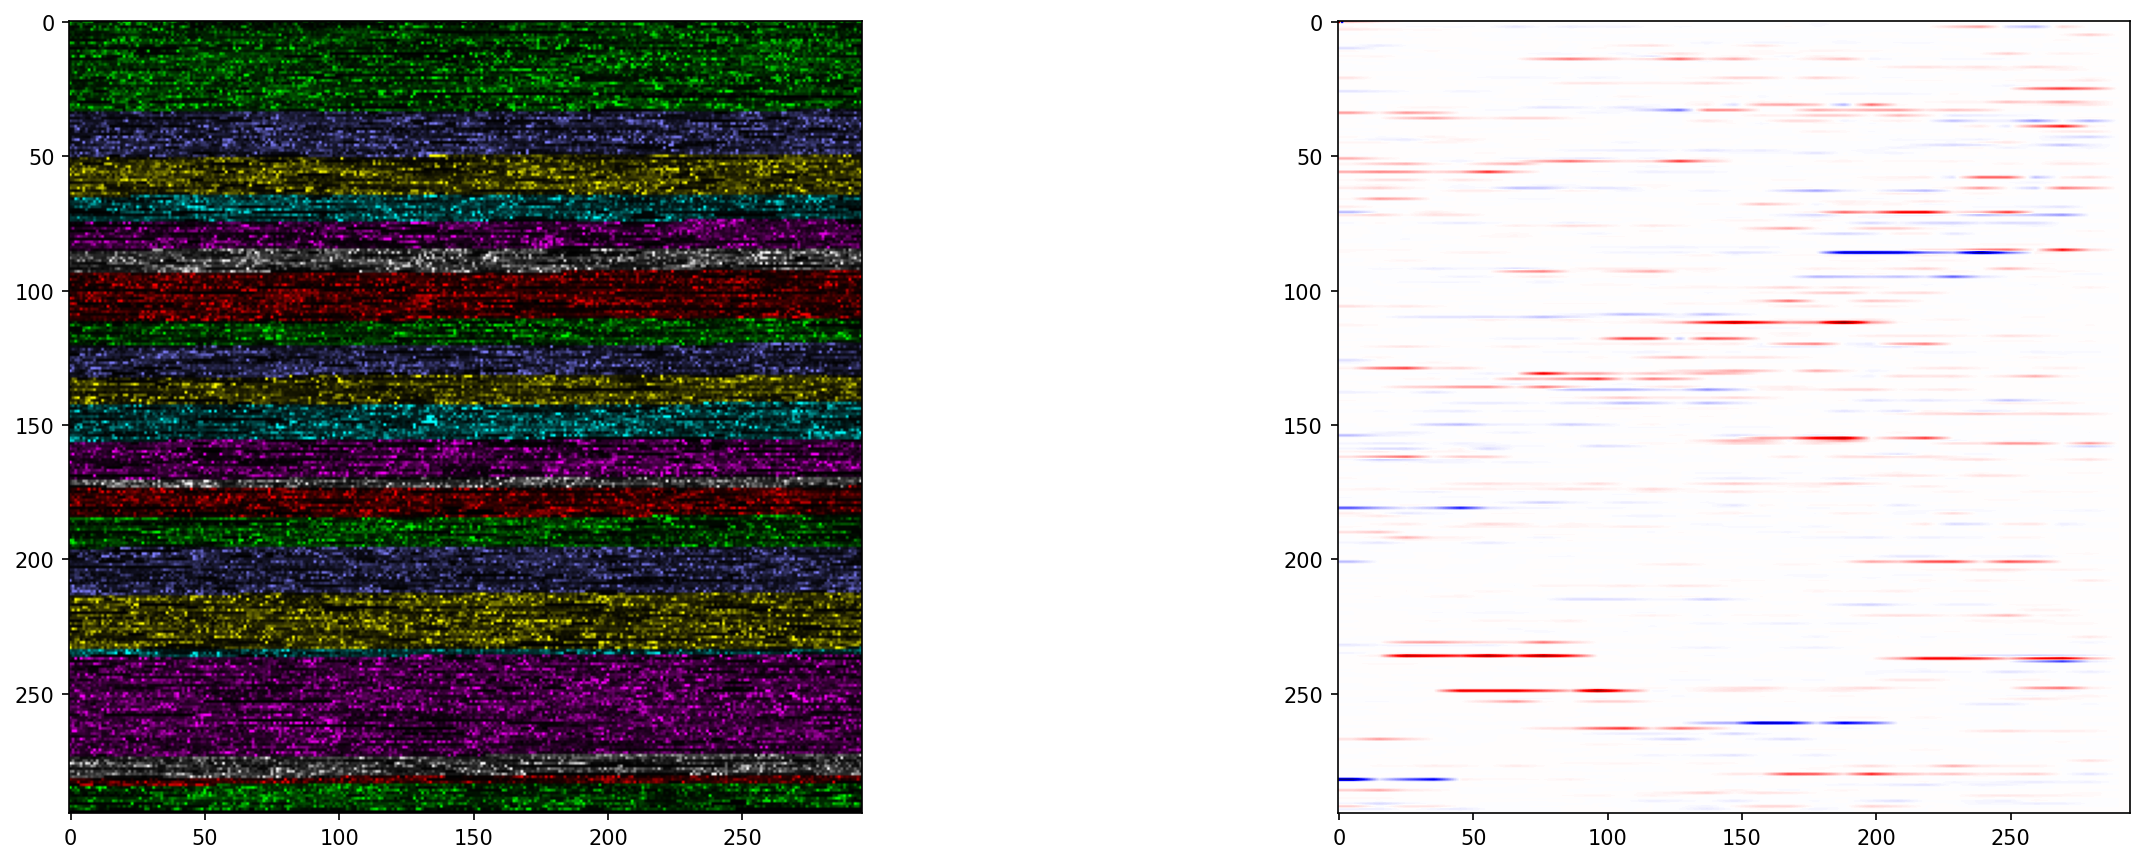

# Conclusion

Compare the two solutions and draw your conclusions 😋